In [30]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines import ACKTR
from stable_baselines.common.vec_env import DummyVecEnv

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Bitcoin Historical Data - Investing.com.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      703 non-null    object
 1   Price     703 non-null    object
 2   Open      703 non-null    object
 3   High      703 non-null    object
 4   Low       703 non-null    object
 5   Vol.      703 non-null    object
 6   Change %  703 non-null    object
dtypes: object(7)
memory usage: 38.6+ KB


In [3]:
df.Price.replace(',','',regex = True, inplace = True)
df.Open.replace(',','',regex = True, inplace = True)
df.High.replace(',','',regex = True, inplace = True)
df.Low.replace(',','',regex = True, inplace = True)
df['Vol.'].replace(to_replace='K', value='', regex=True, inplace = True)
df['Vol.'].replace(to_replace='M', value='', regex=True, inplace = True)
df['Change %'].replace(to_replace='%', value='', regex=True, inplace = True)
df.iloc[:, 1:] = df.iloc[:, 1:].astype(float, copy = False)
df.Date = pd.to_datetime(df.Date, format = '%b %d, %Y')
df = df.drop(columns=['Change %', 'Vol.'])
df = df.rename(columns = {'Price' : 'Close'})
df.set_index('Date', inplace = True)
df.sort_index(inplace = True)
#df = df.sort_values('Date', ignore_index = True)

df



,Close,Open,High,Low
Date,,,,
2020-03-01,8540.0,8543.8,8737.2,8437.2
2020-03-02,8904.8,8537.5,8961.8,8503.1
2020-03-03,8761.4,8906.1,8911.7,8669.3
2020-03-04,8757.9,8761.3,8840.3,8679.7
2020-03-05,9060.3,8757.9,9147.3,8751.5
...,...,...,...,...
2022-01-28,37745.1,37195.6,37995.9,36176.5
2022-01-29,38170.8,37736.5,38663.7,37350.2
2022-01-30,37917.7,38167.5,38313.3,37390.6


In [12]:
window_size = 50
start_index = window_size + 450
end_index = len(df)


env_maker = lambda: gym.make(
    'stocks-v0',
    df = df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([env_maker])

In [31]:
model = ACKTR('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

Wrapping the env in a DummyVecEnv.









---------------------------------
| explained_variance | 3.39e-05 |
| fps                | 6        |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| policy_loss        | 218      |
| total_timesteps    | 20       |
| value_loss         | 3.96e+06 |
---------------------------------
----------------------------------
| explained_variance | -0.000407 |
| fps                | 298       |
| nupdates           | 100       |
| policy_entropy     | 0.659     |
| policy_loss        | -1.09e+03 |
| total_timesteps    | 2000      |
| value_loss         | 4.19e+06  |
----------------------------------
---------------------------------
| explained_variance | -2.5e-05 |
| fps                | 374      |
| nupdates           | 200      |
| policy_entropy     | 0.141    |
| policy_loss        | -2.1e+03 |
| total_timesteps    | 4000     |
| value_loss         | 7.51e+07 |
---------------------------------
-----------------------------

In [32]:
env = env_maker()
observation = env.reset()
rewards = []

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)
    rewards.append(info['total_reward'])

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 29379.70000000001, 'total_profit': 1.0996144104000405, 'position': 1}


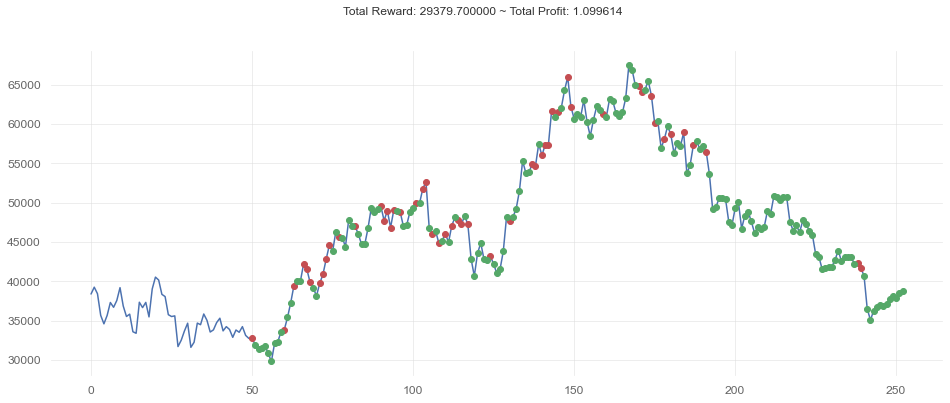

In [33]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

                           Strategy
-------------------------  ----------
Start Period               2021-07-16
End Period                 2022-02-01
Risk-Free Rate             0.0%
Time in Market             16.0%

Cumulative Return          9.96%
CAGR﹪                     18.92%

Sharpe                     0.51
Prob. Sharpe Ratio         67.97%
Smart Sharpe               0.51
Sortino                    0.7
Smart Sortino              0.7
Sortino/√2                 0.49
Smart Sortino/√2           0.49
Omega                      1.25

Max Drawdown               -32.15%
Longest DD Days            78
Volatility (ann.)          39.48%
Calmar                     0.59
Skew                       -2.23
Kurtosis                   37.53

Expected Daily %           0.05%
Expected Monthly %         1.19%
Expected Yearly %          4.86%
Kelly Criterion            9.93%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.01%
Expected Shortfall (cVaR)  -4.01%

Max Consecutive Wins       1


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-15,2022-02-01,2022-02-01,78,-32.149590,-27.549993
2,2021-09-08,2021-09-26,2021-10-09,31,-10.537118,-9.878950
3,2021-10-12,2021-10-17,2021-10-20,8,-4.399320,-3.999558
4,2021-08-29,2021-08-29,2021-09-03,5,-1.736140,0.000000
5,2021-10-31,2021-10-31,2021-11-11,11,-0.489829,0.000000


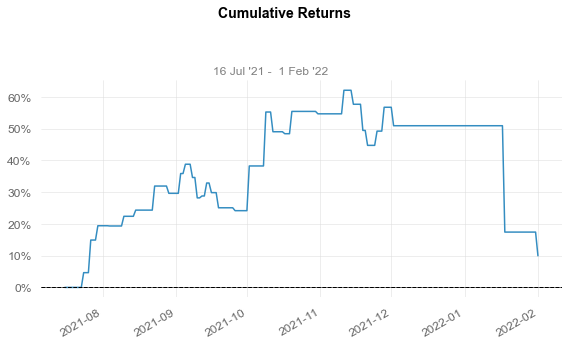

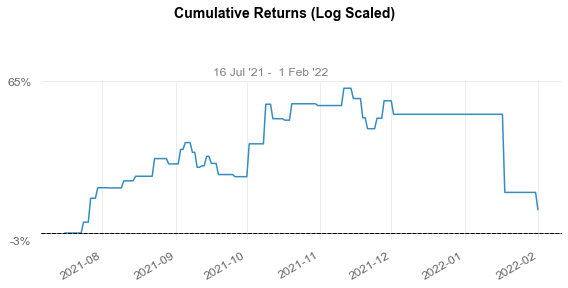

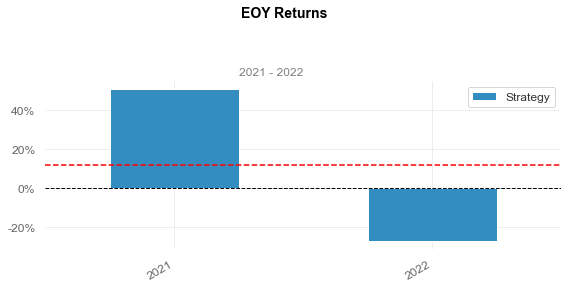

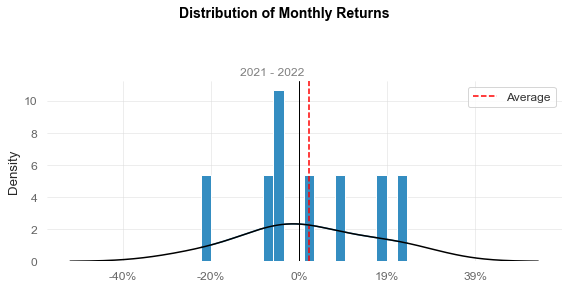

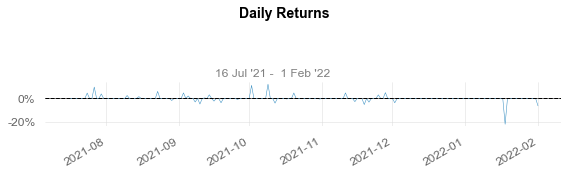

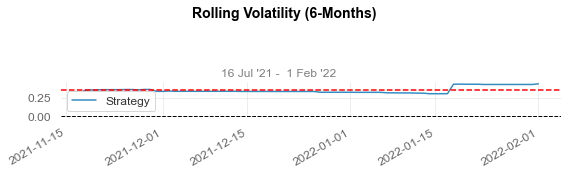

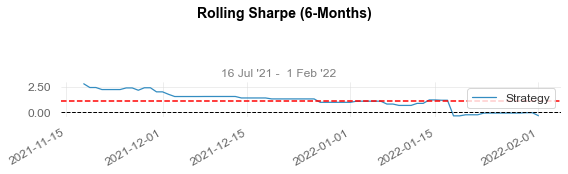

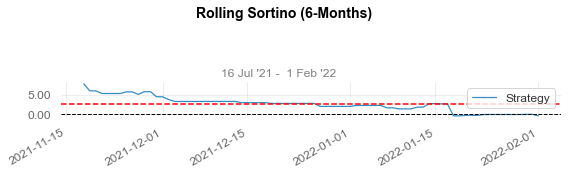

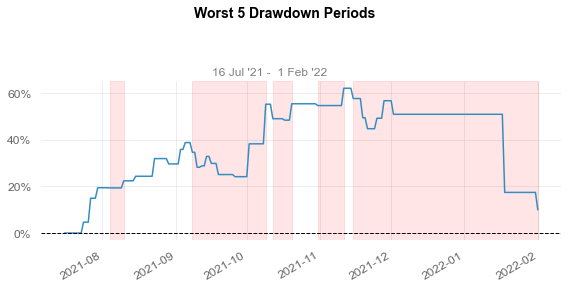

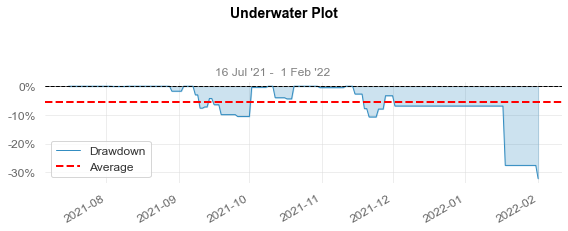

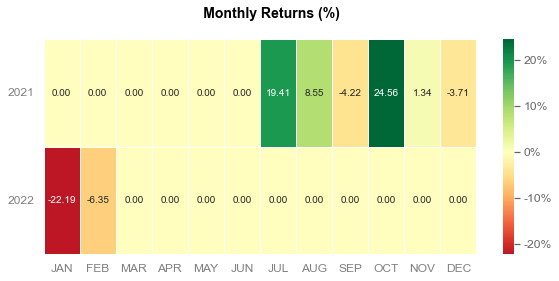

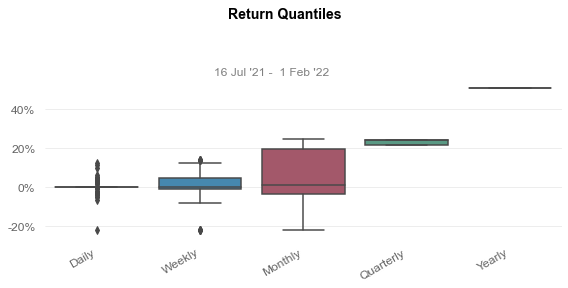

In [34]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_mlplstm_quantstats.html')

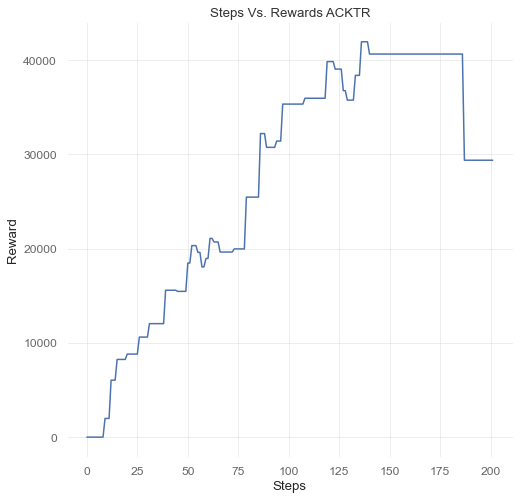

In [41]:
plt.figure(figsize=(8,8))
plt.plot(range(len(rewards)), rewards)
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('Steps Vs. Rewards ACKTR')
plt.savefig('acktr_reward.png')